In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import os

from recurrent_health_events_prediction.visualization.utils import plot_hidden_risk_over_time

# Define the color palette using Plotly's qualitative colors
plotly_colors = px.colors.qualitative.Plotly
sns.set_palette(plotly_colors)

## Last Events with HMM Features

In [14]:
file_dir = "/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_mimic_time_log_gamma"
filename = "last_events_with_hidden_states.csv"
filepath = os.path.join(file_dir, filename)
print("Loadding last events with hidden states from:", filepath)
last_events_hmm_features_df = pd.read_csv(filepath)

Loadding last events with hidden states from: /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_mimic_time_log_gamma/last_events_with_hidden_states.csv


In [15]:
last_events_hmm_features_df["EVENT_DURATION"].describe()

count    1369.000000
mean       77.910881
std        46.308373
min         2.075000
25%        28.319444
50%       103.786111
75%       120.000000
max       120.000000
Name: EVENT_DURATION, dtype: float64

In [16]:
last_events_hmm_features_df.columns

Index(['index', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'ADMISSION_TYPE', 'ETHNICITY', 'INSURANCE', 'HOSPITALIZATION_DAYS',
       'NUM_COMORBIDITIES', 'TYPES_COMORBIDITIES', 'HAS_DIABETES', 'HAS_COPD',
       'HAS_CONGESTIVE_HF', 'NEXT_ADMISSION_TYPE', 'NUM_PREV_HOSPITALIZATIONS',
       'PREV_DISCHTIME', 'NEXT_ADMITTIME', 'DAYS_SINCE_LAST_HOSPITALIZATION',
       'DAYS_UNTIL_NEXT_HOSPITALIZATION',
       'LOG_DAYS_SINCE_LAST_HOSPITALIZATION',
       'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION', 'PREV_READMISSION_30_DAYS',
       'READMISSION_30_DAYS', 'READM_30_DAYS_PAST_MEAN',
       'READM_30_DAYS_PAST_SUM', 'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_MEDIAN',
       'LOG_DAYS_UNTIL_NEXT_HOSP_PAST_STD', 'TOTAL_HOSPITALIZATIONS',
       'DAYS_IN_ICU', 'NUM_DRUGS', 'NUM_PROCEDURES', 'GENDER', 'DOB', 'DOD',
       'DOD_HOSP', 'AGE', 'CHARLSON_INDEX', 'FIRST_ADMITTIME',
       'LAST_DISCHTIME', 'PARTICIPATION_DAYS', 'TOTAL_PARTICIPATION_DAYS',

In [17]:
from recurrent_health_events_prediction.training.utils_hmm import sort_state_labels_by_severity

hidden_states_ordered = last_events_hmm_features_df["HEALTH_HIDDEN_RISK"].unique()
hidden_states_ordered = sort_state_labels_by_severity(hidden_states_ordered)
print("Unique hidden states ordered:", hidden_states_ordered)

Unique hidden states ordered: ['high', 'medium', 'low']


In [18]:
last_readmissions_with_hmm_features_df = last_events_hmm_features_df[last_events_hmm_features_df['READMISSION_EVENT'] == 1]
last_hosp_no_readmissions_with_hmm_features_df = last_events_hmm_features_df[last_events_hmm_features_df['READMISSION_EVENT'] == 0]
hidden_states_count_patients_readmission_s = last_readmissions_with_hmm_features_df["HEALTH_HIDDEN_RISK"].value_counts()
hidden_states_count_patients_no_readmission_s = last_hosp_no_readmissions_with_hmm_features_df["HEALTH_HIDDEN_RISK"].value_counts()

compare_df = pd.DataFrame({
    'Readmission': hidden_states_count_patients_readmission_s,
    'No Readmission': hidden_states_count_patients_no_readmission_s
})
compare_df

,Readmission,No Readmission
HEALTH_HIDDEN_RISK,,
high,245,172
low,125,214
medium,351,262


### Event Duration Dist. per Hidden State

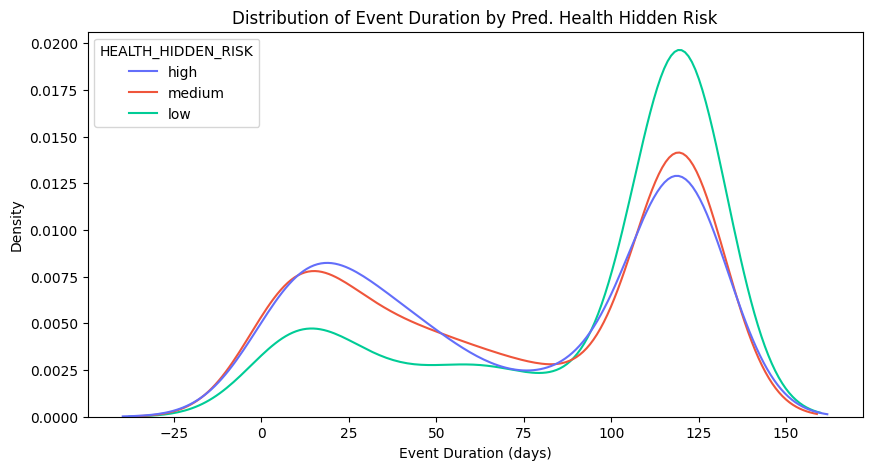

In [19]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    last_events_hmm_features_df,
    x='EVENT_DURATION',
    hue='HEALTH_HIDDEN_RISK',
    common_norm=False,
    hue_order=hidden_states_ordered,
)
plt.title('Distribution of Event Duration by Pred. Health Hidden Risk')
plt.xlabel('Event Duration (days)')
plt.ylabel('Density')
plt.show()

In [20]:
print("Categorical time: ", last_events_hmm_features_df['READMISSION_TIME_CAT'].unique())

Categorical time:  ['120+' '30-120' '0-30']


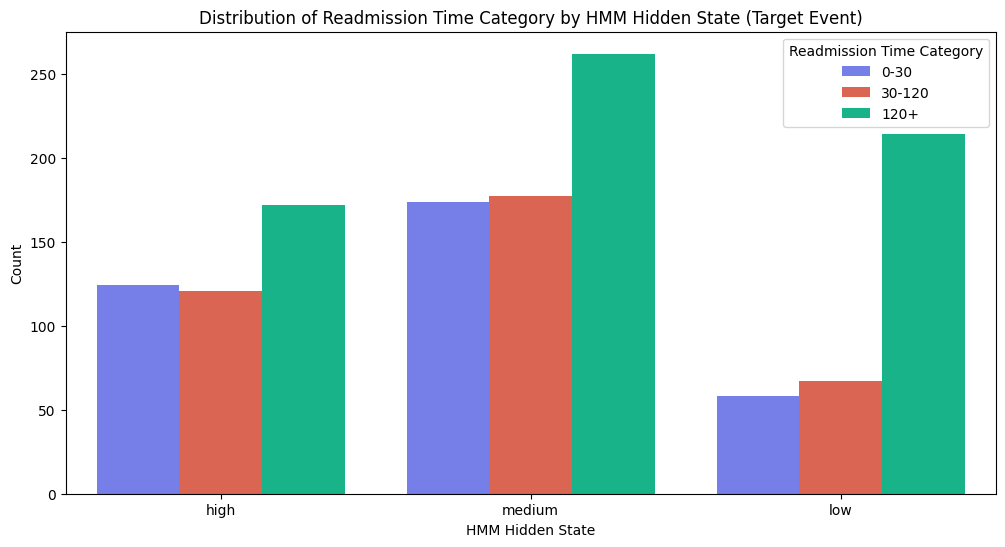

In [21]:
from recurrent_health_events_prediction.training.utils_hmm import plot_cat_event_time_by_hidden_state

fig = plot_cat_event_time_by_hidden_state(
    last_events_hmm_features_df,
    time_cat_col="READMISSION_TIME_CAT",
    title_suffix=" (Target Event)",
    event_name="readmission",
    hue_order=['0-30', '30-120', '120+'],
    hidden_states_order=hidden_states_ordered,
    show_plot=True,
)

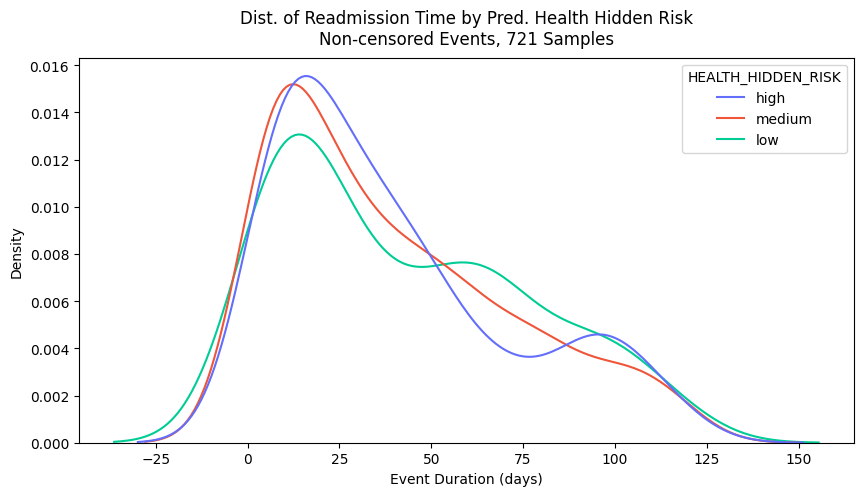

In [22]:
plt.figure(figsize=(10, 5))
sns.kdeplot(
    last_readmissions_with_hmm_features_df,
    x="EVENT_DURATION",
    hue="HEALTH_HIDDEN_RISK",
    common_norm=False,
    hue_order=hidden_states_ordered,
)
plt.title(
    f"Dist. of Readmission Time by Pred. Health Hidden Risk\nNon-censored Events, {len(last_readmissions_with_hmm_features_df)} Samples",
    pad=10
)
plt.xlabel("Event Duration (days)")
plt.ylabel("Density")
plt.show()

In [23]:
import plotly.express as px

px.box(last_readmissions_with_hmm_features_df,
        x='HEALTH_HIDDEN_RISK', y='EVENT_DURATION',
        color='HEALTH_HIDDEN_RISK',
        category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
        title=f"Readmission Time by Pred. Hidden Risk State<br>Non-censored Events, {len(last_readmissions_with_hmm_features_df)} Samples",
        labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk', 'EVENT_DURATION': 'Readmission Time (days)'},)

### Correlation of HMM Features with Readmission Time

In [24]:
hmm_features = [col for col in last_readmissions_with_hmm_features_df.columns if 'PROB_HIDDEN_RISK' in col or 'PAST_COUNT' in col]
print("HMM numerical features to analyze:", hmm_features)

HMM numerical features to analyze: ['PROB_HIDDEN_RISK_HIGH', 'PROB_HIDDEN_RISK_MEDIUM', 'PROB_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_HIGH', 'PAST_COUNT_HIDDEN_RISK_LOW', 'PAST_COUNT_HIDDEN_RISK_MEDIUM']


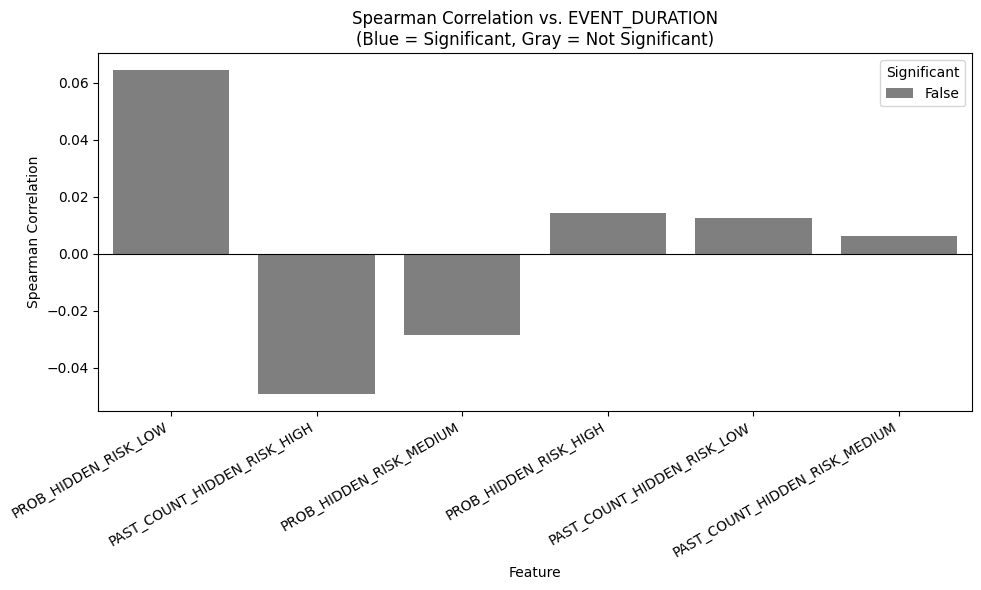

In [25]:
from recurrent_health_events_prediction.eda.utils import plot_spearman_vs_target

fig, corr_df = plot_spearman_vs_target(df=last_readmissions_with_hmm_features_df, numerical_features=hmm_features, target='EVENT_DURATION')

#### Kruskal-Wallis H-Test: Statistical Background

The **Kruskal-Wallis H-test** is a **non-parametric statistical test** used to determine whether there are statistically significant differences between the distributions of a continuous variable across three or more independent groups.

**What is the statistic being tested?**

* The test statistic, **H**, compares the mean ranks of the groups.
* It tests the **null hypothesis ($H_0$):** all groups come from the same distribution (i.e., their population medians are equal).

**Distributional Assumptions:**

* The Kruskal-Wallis test **does not assume normality**.
* It is appropriate for data that are **not normally distributed** and is often used as a non-parametric alternative to one-way ANOVA.
* The only assumptions are:

  * The observations are independent.
  * The variable is at least ordinal.
  * The distributions have the same shape (though the test is robust to differences in shape).

**Summary:**
The Kruskal-Wallis test is ideal when comparing more than two groups with continuous or ordinal data, especially when the normality assumption is questionable.

In [26]:
from scipy.stats import kruskal

# Create a dictionary to store groups for the Kruskal-Wallis test
groups = {state: last_readmissions_with_hmm_features_df[last_readmissions_with_hmm_features_df['HEALTH_HIDDEN_RISK'] == state]['EVENT_DURATION'] for state in hidden_states_ordered}
print("Performing Kruskal-Wallis test for Event Duration by Health Hidden Risk State...")
print("Groups for Kruskal-Wallis test:", groups.keys())
# Check if all groups have more than one sample
for state, group in groups.items():
    if len(group) < 2:
        print(f"Warning: Group '{state}' has only {len(group)} sample(s), which may affect the test results.")
print("Number of samples in each group:")
for state, group in groups.items():
    print(f"{state}: {len(group)} sample(s)")
# Perform the Kruskal-Wallis test
H, p = kruskal(*groups.values())
print(f"Kruskal-Wallis H={H}, p={p}")

Performing Kruskal-Wallis test for Event Duration by Health Hidden Risk State...
Groups for Kruskal-Wallis test: dict_keys(['high', 'medium', 'low'])
Number of samples in each group:
high: 245 sample(s)
medium: 351 sample(s)
low: 125 sample(s)
Kruskal-Wallis H=0.7153975821869029, p=0.6992836737585637


In [27]:
print(last_readmissions_with_hmm_features_df.groupby('HEALTH_HIDDEN_RISK')['EVENT_DURATION'].describe())

                    count       mean        std       min        25%  \
HEALTH_HIDDEN_RISK                                                     
high                245.0  39.711984  32.049031  2.136111  13.005556   
low                 125.0  42.622144  33.608299  2.076389  13.235417   
medium              351.0  39.438155  32.174981  2.075000  11.345833   

                          50%        75%         max  
HEALTH_HIDDEN_RISK                                    
high                29.344444  55.009722  119.238194  
low                 33.172917  66.830556  117.090972  
medium              30.203472  60.185417  119.997222  


### Distributions of Hidden States

In [28]:
import plotly.express as px

px.histogram(last_events_hmm_features_df, x='HEALTH_HIDDEN_RISK', color='HEALTH_HIDDEN_RISK',
    title="Distribution of Pred. Health Hidden Risk States for Readmitted Patients within 120 days (Target Event)",
    labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk'},
    category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
    text_auto=True,
    color_discrete_sequence=px.colors.qualitative.Plotly
).update_layout(
    xaxis_title="Health Hidden Risk",
    yaxis_title="Count",
    legend_title_text="Health Hidden Risk"
).show()

In [29]:
import plotly.express as px

probs_last_readmissions_df = last_readmissions_with_hmm_features_df.copy()
prob_cols = [col for col in probs_last_readmissions_df.columns if col.startswith("PROB_HIDDEN_RISK_")]
probs_last_readmissions_df['HIDDEN_STATE_PROB'] = probs_last_readmissions_df[prob_cols].max(axis=1)

px.box(probs_last_readmissions_df, x='HEALTH_HIDDEN_RISK', y='HIDDEN_STATE_PROB', color='HEALTH_HIDDEN_RISK',
    title="Probability of Pred. Hidden Risk State for Readmitted Patients within 120 days (Target Event)",
    labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk', 'HIDDEN_STATE_PROB': 'Probability of Hidden Risk State'},
    category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
    color_discrete_sequence=px.colors.qualitative.Plotly
).update_layout(
    xaxis_title="Health Hidden Risk",
    yaxis_title="Probability of Hidden Risk State",
    legend_title_text="Health Hidden Risk"
).show()

probs_last_readmissions_df

,index,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,...,DISCHARGE_LOCATION_HOME,DISCHARGE_LOCATION_POST_ACUTE_CARE,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_HIGH,PROB_HIDDEN_RISK_MEDIUM,PROB_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_HIGH,PAST_COUNT_HIDDEN_RISK_LOW,PAST_COUNT_HIDDEN_RISK_MEDIUM,HIDDEN_STATE_PROB
3,3,256,188869,2170-06-15 03:06:00,2170-06-27 16:17:00,EMERGENCY,WHITE,Medicare,12.549306,4,...,0,1,high,0.642921,0.245272,0.111807,0,2,0,0.642921
6,6,323,128132,2119-09-21 20:34:00,2119-10-06 18:50:00,EMERGENCY,WHITE,Medicare,14.927778,4,...,0,1,high,0.852940,0.052581,0.094478,0,2,0,0.852940
8,8,357,101651,2199-10-20 12:05:00,2199-10-23 17:30:00,EMERGENCY,WHITE,Private,3.225694,5,...,0,1,medium,0.367048,0.474163,0.158788,2,0,1,0.474163
12,12,518,185375,2111-07-06 14:36:00,2111-07-14 19:30:00,EMERGENCY,BLACK/AFRICAN,Medicare,8.204167,3,...,1,0,low,0.224567,0.268323,0.507110,0,1,6,0.507110
15,15,665,152089,2119-02-25 20:13:00,2119-02-27 20:53:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicaid,2.027778,4,...,1,0,low,0.229609,0.382118,0.388272,0,1,0,0.388272
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1360,1360,98593,176136,2193-02-21 16:51:00,2193-03-05 19:30:00,EMERGENCY,WHITE,Private,12.110417,5,...,0,1,high,0.537195,0.345755,0.117050,1,0,0,0.537195
1362,1362,99346,177015,2142-05-13 13:17:00,2142-05-24 17:20:00,EMERGENCY,WHITE,Medicare,11.168750,4,...,0,1,medium,0.383782,0.492548,0.123670,0,0,1,0.492548
1363,1363,99384,168087,2117-12-15 18:12:00,2117-12-23 15:25:00,EMERGENCY,WHITE,Medicare,7.884028,6,...,0,1,medium,0.222486,0.754957,0.022557,0,0,1,0.754957
1364,1364,99439,152370,2179-09-29 16:19:00,2179-10-04 16:45:00,EMERGENCY,BLACK/AFRICAN AMERICAN,Medicare,5.018056,6,...,0,1,medium,0.236987,0.714489,0.048524,1,0,2,0.714489


In [30]:
prob_cols = [col for col in probs_last_readmissions_df.columns if col.startswith("PROB_HIDDEN_RISK_")]
agg_dict = {col: ['mean', 'std'] for col in prob_cols}
agg_dict['HADM_ID'] = 'count'

probs_per_hidden_state_summary_df = probs_last_readmissions_df.groupby('HEALTH_HIDDEN_RISK').agg(agg_dict).reset_index().rename(columns={
    'HADM_ID': 'Count'})

# Flatten the multi-index columns for easier plotting
probs_per_hidden_state_summary_df.columns = ['_'.join(col).strip() for col in probs_per_hidden_state_summary_df.columns.values]

# Rename columns for clarity
mean_cols = [col for col in probs_per_hidden_state_summary_df.columns if '_mean' in col]
std_cols = [col for col in probs_per_hidden_state_summary_df.columns if '_std' in col]
rename_mean_dict = {col: col.replace('_mean', '').replace('PROB_HIDDEN_RISK_', '') for col in mean_cols}
rename_std_dict = {col: col.replace('_std', '_STD').replace('PROB_HIDDEN_RISK_', '') for col in std_cols}
rename_dict = {**rename_mean_dict, **rename_std_dict, 'HEALTH_HIDDEN_RISK_': 'HEALTH_HIDDEN_RISK', 'Count_count': 'Count'}
probs_per_hidden_state_summary_df = probs_per_hidden_state_summary_df.rename(columns=rename_dict)
probs_per_hidden_state_summary_df


,HEALTH_HIDDEN_RISK,HIGH,HIGH_STD,MEDIUM,MEDIUM_STD,LOW,LOW_STD,Count
0,high,0.651401,0.197122,0.189206,0.132553,0.158959,0.103901,245
1,low,0.246567,0.064013,0.257861,0.077834,0.495572,0.081899,125
2,medium,0.255107,0.089058,0.563665,0.117805,0.181228,0.097158,351


In [31]:

# Melt the dataframe for easier plotting
melted_df = probs_per_hidden_state_summary_df.melt(
    id_vars=['HEALTH_HIDDEN_RISK'],
    value_vars=[label for label in rename_mean_dict.values()],
    var_name='Probability_Type',
    value_name='Mean_Probability'
)

# Add standard deviation values
std_values = probs_per_hidden_state_summary_df.melt(
    id_vars=['HEALTH_HIDDEN_RISK'],
    value_vars=[label for label in rename_std_dict.values()],
    var_name='Probability_Type_Std',
    value_name='Std_Deviation'
)

# Merge mean and std data
melted_df['Std_Deviation'] = std_values['Std_Deviation']

# Plot using Plotly
fig = px.bar(
    melted_df,
    x='Probability_Type',
    y='Mean_Probability',
    error_y='Std_Deviation',
    color='Probability_Type',
    facet_col='HEALTH_HIDDEN_RISK',
    facet_col_wrap=2,
    title="Distribution of Probabilities with Standard Deviation",
    labels={'Probability_Type': 'Probability Hidden Risk', 'Mean_Probability': 'Mean Probability', 'HEALTH_HIDDEN_RISK': 'Health Hidden Risk'},
    category_orders={'HEALTH_HIDDEN_RISK': hidden_states_ordered},
    color_discrete_sequence=px.colors.qualitative.Plotly,
    height=600
)

fig.update_layout(
    xaxis_title="Probability Hidden Risk",
    yaxis_title="Mean Probability",
    legend_title_text="Probability Hidden Risk",
)

# Apply tick angle to all x-axes in the facets
for axis in fig.layout:
    if axis.startswith('xaxis'):
        fig.layout[axis].tickangle = -45

fig.show()

## Historical Events with HMM Features

In [2]:
model_name = "hmm_mimic_time_log_gamma"
model_dir = f"/workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/{model_name}"
filepath = os.path.join(model_dir, "training_seq_with_probs.csv")
historical_events_hmm_features_df = pd.read_csv(filepath)

In [3]:
historical_events_hmm_features_df['ADMITTIME'] = pd.to_datetime(historical_events_hmm_features_df['ADMITTIME'])
historical_events_hmm_features_df['DISCHTIME'] = pd.to_datetime(historical_events_hmm_features_df['DISCHTIME'])

In [4]:
from recurrent_health_events_prediction.model.RecurrentHealthEventsHMM import RecurrentHealthEventsHMM
from recurrent_health_events_prediction.model.utils import load_model

model_path = os.path.join(model_dir, f"{model_name}.pkl")
print(f"Loading model from {model_path}")
hmm_feature_extractor_model: RecurrentHealthEventsHMM = load_model(model_path)

Loading model from /workspaces/master-thesis-recurrent-health-events-prediction/_models/mimic/hmm/hmm_mimic_time_log_gamma/hmm_mimic_time_log_gamma.pkl


In [5]:
distributions_params_df = hmm_feature_extractor_model.get_features_dist_df(include_state_labels=True)
styled_df = distributions_params_df.style.set_table_styles(
    [{'selector': 'th', 'props': [('font-size', '12px'), ('text-align', 'center')]},
     {'selector': 'td', 'props': [('font-size', '12px'), ('text-align', 'center')]}]
).set_properties(**{'border': '1px solid black', 'padding': '5px'})

styled_df

In [6]:
from recurrent_health_events_prediction.training.utils_hmm import sort_state_labels_by_severity

hidden_state_labels_order = sort_state_labels_by_severity(list(hmm_feature_extractor_model.get_hidden_state_labels().values()))

In [7]:
import plotly.express as px

px.box(historical_events_hmm_features_df,
        x='HEALTH_HIDDEN_RISK', y='DAYS_UNTIL_NEXT_HOSPITALIZATION',
        color='HEALTH_HIDDEN_RISK',
        category_orders={'HEALTH_HIDDEN_RISK': hidden_state_labels_order},
        title="True Days Until Next Hospit by Pred. Hidden Risk State - Training Data HMM",
        labels={'HEALTH_HIDDEN_RISK': 'Health Hidden Risk', 'DAYS_UNTIL_NEXT_HOSPITALIZATION': 'True Days Until Next Hospitalization'})

In [8]:
import plotly.express as px

probs_hist_readmissions_df = historical_events_hmm_features_df.copy()
probs_hist_readmissions_df['HIDDEN_STATE_PROB'] = probs_hist_readmissions_df[[col for col in probs_hist_readmissions_df.columns if col.startswith("PROB_HIDDEN_RISK_")]].max(axis=1)

px.box(probs_hist_readmissions_df, x='HEALTH_HIDDEN_RISK', y='HIDDEN_STATE_PROB', color='HEALTH_HIDDEN_RISK',
    title="Probability of Pred. Hidden Risk State - Training Data HMM",
    labels={'HEALTH_HIDDEN_RISK': 'Pred. Health Hidden Risk', 'HIDDEN_STATE_PROB': 'Pred. Probability of Hidden Risk State'},
    category_orders={'HEALTH_HIDDEN_RISK': ['high', 'medium', 'low', 'very_low']},
    color_discrete_sequence=px.colors.qualitative.Plotly
).update_layout(
    legend_title_text="Pred. Health Hidden Risk"
).show()

probs_hist_readmissions_df

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,ADMISSION_TYPE,ETHNICITY,INSURANCE,HOSPITALIZATION_DAYS,NUM_COMORBIDITIES,TYPES_COMORBIDITIES,...,IS_HISTORICAL_EVENT,READMISSION_TIME_CAT,READMISSION_TIME_CAT_ENCODED,DISCHARGE_LOCATION_HOME,DISCHARGE_LOCATION_POST_ACUTE_CARE,HEALTH_HIDDEN_RISK,PROB_HIDDEN_RISK_LOW,PROB_HIDDEN_RISK_MEDIUM,PROB_HIDDEN_RISK_HIGH,HIDDEN_STATE_PROB
0,36,182104,2131-04-30 07:15:00,2131-05-08 14:00:00,EMERGENCY,WHITE,Medicare,8.281250,2,"['other', 'chronic_pulmonary_disease']",...,1,0-30,0,1,0,high,2.514377e-12,0.285634,0.714366,0.714366
1,107,191941,2115-02-20 17:41:00,2115-02-21 16:30:00,EMERGENCY,HISPANIC OR LATINO,Private,0.950694,2,"['other', 'renal_disease']",...,1,120+,2,1,0,low,8.999964e-01,0.057818,0.042186,0.899996
2,124,172461,2160-06-24 21:25:00,2160-07-15 15:10:00,EMERGENCY,WHITE,Private,20.739583,3,"['other', 'chronic_pulmonary_disease', 'cerebr...",...,1,120+,2,1,0,low,9.155658e-01,0.042237,0.042198,0.915566
3,124,112906,2161-12-17 03:39:00,2161-12-24 15:35:00,EMERGENCY,WHITE,Medicare,7.497222,3,"['peripheral_vascular_disease', 'other', 'chro...",...,1,120+,2,1,0,low,7.850250e-01,0.076159,0.138815,0.785025
4,138,108120,2131-10-31 08:00:00,2131-11-06 12:54:00,ELECTIVE,WHITE,Private,6.204167,4,"['congestive_heart_failure', 'myocardial_infar...",...,1,120+,2,1,0,low,9.450083e-01,0.029305,0.025686,0.945008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3371,99469,189343,2181-10-16 16:02:00,2181-10-23 15:35:00,EMERGENCY,WHITE,Medicare,6.981250,4,"['congestive_heart_failure', 'other', 'chronic...",...,1,120+,2,1,0,low,4.833263e-01,0.343950,0.172724,0.483326
3372,99503,132396,2124-04-13 12:00:00,2124-04-13 17:14:00,ELECTIVE,WHITE,Medicare,0.500000,2,"['other', 'renal_disease']",...,1,120+,2,1,0,low,9.239952e-01,0.032653,0.043352,0.923995
3373,99556,107452,2165-12-25 12:44:00,2166-01-08 16:53:00,EMERGENCY,WHITE,Medicare,14.172917,5,"['myocardial_infarct', 'other', 'congestive_he...",...,1,120+,2,0,1,medium,3.667355e-01,0.374888,0.258377,0.374888
3374,99650,190854,2152-06-07 11:30:00,2152-06-13 15:00:00,ELECTIVE,WHITE,Medicare,6.145833,5,"['chronic_pulmonary_disease', 'other', 'periph...",...,1,120+,2,1,0,low,8.775163e-01,0.067609,0.054875,0.877516


In [9]:
subject_id = 5901
prob_cols = [col for col in historical_events_hmm_features_df.columns if col.startswith("PROB_HIDDEN_RISK_")]
time_col = ['ADMITTIME']
subject_df = historical_events_hmm_features_df.loc[historical_events_hmm_features_df['SUBJECT_ID'] == subject_id, time_col + prob_cols]

In [10]:
list(hmm_feature_extractor_model.config['features'].keys())

['CHARLSON_INDEX',
 'DISCHARGE_LOCATION_POST_ACUTE_CARE',
 'LOG_DAYS_IN_ICU',
 'LOG_DAYS_UNTIL_NEXT_HOSPITALIZATION']

In [11]:
from recurrent_health_events_prediction.visualization.utils import plot_subject_evolution


features_to_plot = [
    'CHARLSON_INDEX',
    'DISCHARGE_LOCATION_POST_ACUTE_CARE',
    'DAYS_IN_ICU',
    'NUM_DRUGS',
    'DAYS_UNTIL_NEXT_HOSPITALIZATION',
]

filename = "readmission_evolution_5901.html"
file_path = os.path.join("/workspaces/master-thesis-recurrent-health-events-prediction/assets/plots/eda/mimic", filename)
plot_subject_evolution(historical_events_hmm_features_df, subject_id, features_to_plot=features_to_plot, textposition='auto', extend_time_horizon_by=30, save_html_file_path=file_path)

Plot saved as /workspaces/master-thesis-recurrent-health-events-prediction/assets/plots/eda/mimic/readmission_evolution_5901.html


In [12]:
filename = "prob_hidden_risk_over_time_donor_10219.html"
filepath = os.path.join("/workspaces/master-thesis-recurrent-health-events-prediction/assets/plots/eda/mimic", filename)
fig = plot_hidden_risk_over_time(
    subject_df,
    time_col="ADMITTIME",
    event_name="Hospitalization",
    title=f"Hidden State Probabilities Over Time - Subject ID: {subject_id}",
    subtitle="Historical Events - Hosp. Readmission Dataset",
    save_html_file_path=filepath,  # or "hidden_risk_plot.html"
)


Plot saved as /workspaces/master-thesis-recurrent-health-events-prediction/assets/plots/eda/mimic/prob_hidden_risk_over_time_donor_10219.html


In [ ]:
mask = last_events_hmm_features_df["SUBJECT_ID"] == subject_id
cols = [
    "PROB_HIDDEN_RISK_HIGH",
    "PROB_HIDDEN_RISK_MEDIUM",
    "PROB_HIDDEN_RISK_LOW",
    "PAST_COUNT_HIDDEN_RISK_HIGH",
    "PAST_COUNT_HIDDEN_RISK_MEDIUM",
    "PAST_COUNT_HIDDEN_RISK_LOW"
]
last_events_hmm_features_df.loc[mask, ["SUBJECT_ID", "HADM_ID", "READMISSION_TIME_CAT", "HEALTH_HIDDEN_RISK"] + cols]